# John Wu
# CSE 5524
# 9/12/22
## Libraries

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.io import imread
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
import scipy
import scipy.ndimage
import matplotlib.image as mpimg
from PIL import Image

# a nice to use plotting function for pyramids.
def plot_multi(listIm):
    f, axarr = plt.subplots(len(listIm),1) 
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    for i in range(len(listIm)):
        axarr[i].imshow(listIm[i], cmap="gray")


## Q.1 
Generate a N=3 level Gaussian pyramid (original image is level-0, you will have level-
0, level-1, level-2, and level-3) and the corresponding Laplacian pyramid of an image
(select an image from the web, make it 1-channel grayscale). First use the formula in
the notes to determine a viable image size (use N=3, and pick integers N_C and N_R ), and
crop the image (if needed) to test the pyramid code. Use a=0.4 for the Gaussian mask
– you must use separable masks! Write/use functions for properly reducing and
expanding an image. Write your own interpolation function - do not use
Matlab/Python in-built interpolation functions (e.g., interp2). Lastly, perform a
reconstruction of the original (cropped) image using the Laplacian pyramid. [8 pts]

In [49]:
def gaussian(x, center, sigma):
    mainTerm = 1 / (np.sqrt(2* np.pi) * (sigma))
    exponentialTerm = np.exp( -np.square(x-center)/(2*sigma*sigma))
    return mainTerm * exponentialTerm

def gaussian_smooth_mask(sigma):
    maskDim = np.ceil(3*sigma) # for this case again we will use 3sigma
    maskSize = 2*int(maskDim) + 1
    center = maskDim
    gX = np.zeros((maskSize,maskSize)) # column
    gY = np.zeros((maskSize,maskSize)) # row (y)
    for r in range(maskSize):
        for c in range(maskSize):
            gX[r,c] = gaussian(c, center, sigma) # col
            gY[r,c] = gaussian(r, center, sigma) # row
            
    gX = gX / np.sum(gX)
    gY = gY / np.sum(gY)
    return [gX, gY]

# in class - blur method
def default_blur_mask(a):
    w = np.array([.25 -.5*a, .25, a, .25, .25 - .5*a])
    gX = np.zeros((w.shape[0], w.shape[0]))
    gY = np.zeros((w.shape[0], w.shape[0]))
    for r in range(w.shape[0]):
        gX[r,:] = w
    for c in range(w.shape[0]):
        gY[:,c] = w
    return gX, gY

def blur_sample(im, a): # apparently a = 1 is gaussian lol
    
    # using separable masks, let us do gX first, then gY, etc.
    # blur
    gX, gY = default_blur_mask(a)

    xBlur = scipy.ndimage.correlate(im, gX, mode='nearest') # equivalent of imFilter on X 
    fullBlur = scipy.ndimage.correlate(xBlur, gY, mode='nearest') # now do y on recently blurred x
    # sample half of the pixels
    rows = int(np.ceil((fullBlur.shape[0] + 1)/ 2)) 
    cols = int(np.ceil((fullBlur.shape[1] + 1) /2)) 
    halvedIm = np.zeros((rows, cols))
    for r in range(rows):
        for c in range(cols):
            halvedIm[r,c] = fullBlur[r*2, c*2]
            
    return halvedIm 

# we will try to do "bilinear" average interpolation or some variant where we average row-wise and then columnwise 
def interpolate(im):
    doubleRows = int((im.shape[0])* 2) - 1 
    doubleCols = int((im.shape[1]) * 2)  - 1
    doubleIm = np.zeros((doubleRows, doubleCols))
    
    # fill in every other pixel
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            doubleIm[2*r, 2*c] = im[r,c]
    
    for r in range(im.shape[0]): # first go x-direction, average every two pixels into one for each row.
        for c in range(im.shape[1] - 1): 
            if c+1 < im.shape[1]: # just in case we're on edge.
                doubleIm[r*2,c*2 + 1] = (im[r,c] + im[r,c+1]) / 2
            else:
                doubleIm[r*2,c*2 + 1] = im[r,c]
    
    for r in range(im.shape[0] - 1): # now go y-direction, average every two above and below pixels into one for each row.
        for c in range(doubleCols): # we want to fill the rest of columns we missed.
            if c % 2 == 1:
                if c + 1 < doubleCols: # corner pixels not on edge
                    if(2*r + 2 < doubleRows):
                        doubleIm[r*2 + 1, c] = (doubleIm[2*r,c - 1] + doubleIm[2*r+2,c+1] + doubleIm[2*r, c + 1] + doubleIm[2*r+2, c-1]) / 4 # do corners
                    else: # corner pixels literally on bottom row.
                        doubleIm[r*2 + 1, c] = (doubleIm[2*r,c -1 ] + doubleIm[2*r, c+1]) / 2
                else:
                    if(2*r + 2 < doubleRows):
                        doubleIm[r*2 + 1, c] = (doubleIm[2*r,c - 1] +  doubleIm[2*r+2, c-1]) / 2 # do closest 2 if on the edge.
                    else: # literally if bottom right corner, we will just take the nearest top left pixel
                        doubleIm[r*2 + 1, c] = doubleIm[2*r,c - 1]
            else: # top to bottom
                if(2*r + 2 < doubleRows):
                    doubleIm[r*2 + 1, c] = (doubleIm[2*r,c] + doubleIm[2*r+2,c]) / 2 # or do top to bottom
                else: # case where we have even number of rows and just so happen to be at the edge. Just take the above row
                    doubleIm[r*2 + 1, c] = doubleIm[2*r,c]
            
    return doubleIm
    
    # now let's average x and y wise 

# n: number of levels in pyramid
# a: value of blur
# returns: a 3D numpy array of a list of laplacian errors (that we can interpolate)
def laplacian_pyramid(im,n,a):
    # since n = 0 is the original image, for n levels, we will want to return a list of n+1 pyramids
    pyramid = [] # we use list because numpy arrays are static dimensional
    currentBlur = im
    for i in range(n):
        # step 1 blur and sample 
        blurImg = blur_sample(currentBlur, a)
        print(blurImg.shape)
        # step 2 interpolate blurred sample
        upSample = interpolate(blurImg)
        # step 3 subtract original image with interpolation to get laplacian error
        laplacian = currentBlur - upSample
        # step 4 store the difference aka error, and keep track of what the current blurred img is
        pyramid.append(laplacian)    
        currentBlur = blurImg
    # copy the last or smallest sampled blurImg into it. 
    pyramid.append(currentBlur)
    return pyramid
    
# pyramid: has thickest signal at lowest index n= 0, while index n has the most sampled signal (smallest image)    
def reproduceOriginalImage(pyramid):
    pyramid.reverse() # reverse the list of images
    pyramidHt = len(pyramid)
    reconstructed= 0
    
    # start with smallest blur and go up.
    for i in range(pyramidHt - 1):
        if i == 0:
            interpolated = interpolate(pyramid[i])
        else:
            interpolated = interpolate(reconstructed) # note we want to make sure the sum is one we're interpolating for reconstructing
        reconstructed = pyramid[i + 1] + interpolated
        
    return reconstructed

In [50]:
# little test bed to see how blurring and interpolating works.
imgTest = np.ones((5,5))
imgTest[0,:] = 0
imgTest[:,0] = 0
imgTest[4,:] = 0
imgTest[:,4] = 0
print(imgTest)
print('------------')
print(blur_sample(imgTest,0.4))
print('-------------------')
print(interpolate(imgTest)) 
print('------------------')
blur = blur_sample(imgTest, 0.4)
interpolated = interpolate(blur)
lap = imgTest - interpolated
blur_again = blur_sample(blur, 0.4)
interpolated_again = interpolate(blur_again)
lap_again = blur - interpolated_again

reconstruct = interpolate((interpolate(blur_again) + lap_again)) + lap
print(np.sum(reconstruct - imgTest))

[[0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]
------------
[[5.75 6.67 5.75]
 [7.25 8.41 7.25]
 [5.75 6.67 5.75]]
-------------------
[[0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.5  0.5  0.5  0.5  0.5  0.25 0.  ]
 [0.   0.5  1.   1.   1.   1.   1.   0.5  0.  ]
 [0.   0.5  1.   1.   1.   1.   1.   0.5  0.  ]
 [0.   0.5  1.   1.   1.   1.   1.   0.5  0.  ]
 [0.   0.5  1.   1.   1.   1.   1.   0.5  0.  ]
 [0.   0.5  1.   1.   1.   1.   1.   0.5  0.  ]
 [0.   0.25 0.5  0.5  0.5  0.5  0.5  0.25 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
------------------
-1.0302869668521453e-13


### Read in Data

(401, 401)


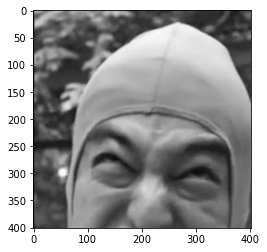

In [51]:

readIm = imread('PinkGuy.png')
greyIm = rgb2gray(readIm) # convert image to grayscale
myIm = greyIm[:401,:401] # crop note that 401 is correct for the burt adelson dimensions.
print(myIm.shape)
plt.imsave('ogIm.png',myIm, cmap='gray')
plt.imshow(myIm, cmap="gray")



### Test for Pyramids USING N=3, a = 0.4
#### Observe that each part of the pyramid gets smaller and smaller in terms of image starting top to bottom.


(201, 201)
(101, 101)
(51, 51)


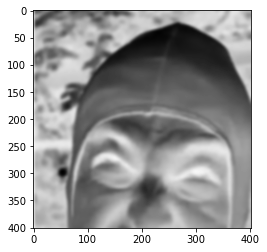

In [52]:

n = 3
a = 0.4
pyr = laplacian_pyramid(myIm, n, a)
# save all of these images from the pyramid
for i in range(n+1):
    plt.imsave("Pyramid" + str(i) + ".png", pyr[i],cmap='gray')

plt.imshow(pyr[0] ,cmap="gray")

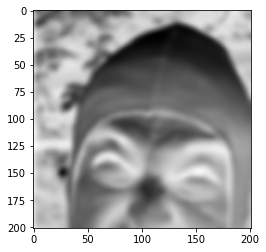

In [53]:
plt.imshow(pyr[1] ,cmap="gray")

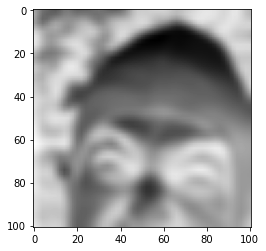

In [54]:
plt.imshow(pyr[2] ,cmap="gray")

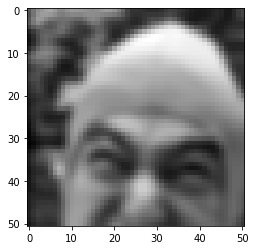

In [55]:
plt.imshow(pyr[3] ,cmap="gray")

### Laplacian Pyramid Displayed Using MarkDown, Note That This Won't Show Up Below in the Report Version, Please Refer To 4 Pictures Earlier to Get Idea of Pyramid (with axis labels).
![alt text](Pyramid0.png "Title")
![alt text](Pyramid1.png "Title")
![alt text](Pyramid2.png "Title")
![alt text](Pyramid3.png "Title")

### Reconstructed

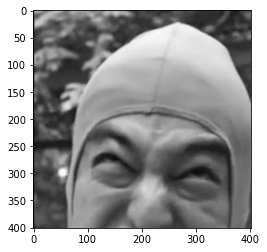

In [56]:
# now let's reproduce the image
reproduced = reproduceOriginalImage(pyr)
plt.imsave('reconstructedIm.png', reproduced, cmap="gray") # note there's a weird jupyter notebook bug where YOU may have to rerun it twice, to get the reconstruction to happen properly
plt.imshow(reproduced, cmap="gray")

### Original

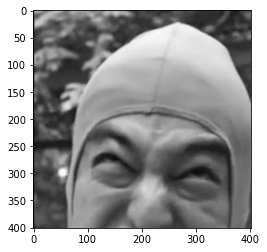

In [78]:
plt.imshow(myIm, cmap='gray')

### Comparing Laplacian Reconstructed Image and Original Image (Again won't show up in PDF because markdown!)
# ORIGINAL
![alt text](ogIm.png "Title")
# REPRODUCED
![alt text](reconstructedIm.png "Title")


In [57]:
np.sum(np.abs(myIm - reproduced)) # SUPER TINY VALUE FOR SANITY CHECKS (IDK)

3.044100888418069e-08

# Key Observations

The laplacian errors are weirdly greyed out to a heavy degree, but different than the ones in class. I am not sure if this is due to matlab and matplotlib having different grayscale presentations or if something has gone wrong with the laplacian computation. That being said, we can reproduce an extremely similar image with a very small numerical difference to the original (i.e 10^-7), which is quite close to 0. Furthermore, the images look the same with the repoduced and the original as shown above. There could be negligible differences that cannot be discerned by the human eye as the error is nonzero for some reason.

# Q.2
### Using the grayscale images (walk.bmp, bg000.bmp) provided on the WWW site, perform background subtraction 1 (abs diff) to extract the object. (Make sure your image is of type double!) Experiment with thresholds and discuss. [2 pts]

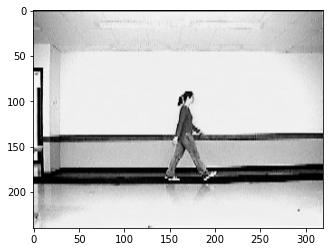

In [58]:
walk = imread('walk.bmp')
plt.imshow(walk, cmap="gray")

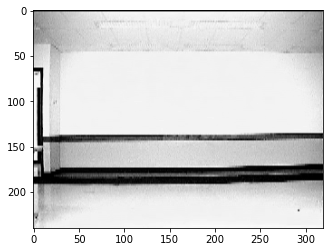

In [59]:
background = imread('bg000.bmp')
plt.imshow(background, cmap="gray")

250.0


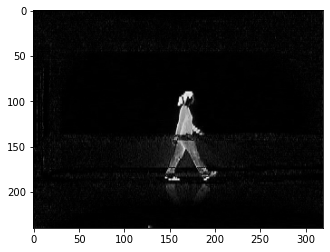

In [60]:
extract1 = np.abs(walk.astype(float) - background.astype(float))
print(np.max(extract1)) # get an idea of what the brightest pixel is
plt.imshow(extract1, cmap="gray")

### We will try different thresholding i.e T_max = 250 T = 25, 50, 100, 150, 200 

In [61]:
T = [25, 50, 100, 150, 200]
extractions1 = []
# get different absolute value difference thresholds.
for t in T: 
    plt.imsave("subtraction1_"+str(t) + ".png", extract1 > t, cmap="gray")
    extractions1.append(extract1 > t)

### T = 25

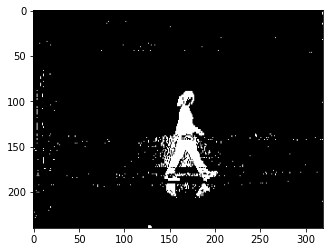

In [62]:
plt.imshow(extractions1[0], cmap='gray')

### T= 50

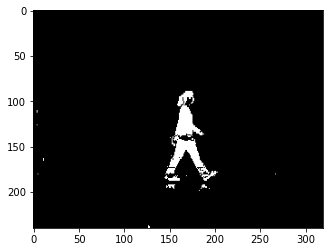

In [63]:
plt.imshow(extractions1[1], cmap='gray')

### T = 100

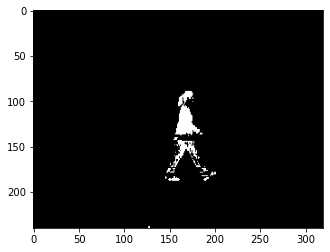

In [64]:
plt.imshow(extractions1[2], cmap='gray')

### T = 150

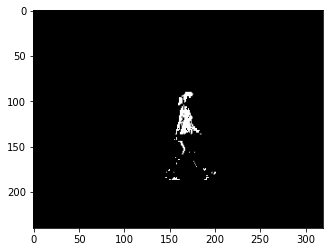

In [65]:
plt.imshow(extractions1[3], cmap='gray')

### T = 200

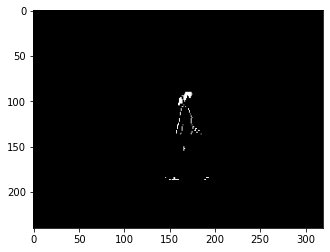

In [66]:
plt.imshow(extractions1[4], cmap='gray')

### Display all thresholdings (Won't Show on PDF Below)


#### T = 25

![alt text](subtraction1_25.png "Title")

#### T = 50
![alt text](subtraction1_50.png "Title")
#### T = 100
![alt text](subtraction1_100.png "Title")
#### T = 150
![alt text](subtraction1_150.png "Title")

#### T = 200
![alt text](subtraction1_200.png "Title")

# Key Observations/ Discussion
#### Important note is that in this question, we only care about the first background 000, which means we are not selecting the best background or a mean background, etc. In this case, observe that the threshold near 50 is the best regarding noise to extract pixel values ratio. While as you increase the threshold, you lose more and more of the person and if you decrease the threshold, you include more noise.

# Q.3 
Using the grayscale images (walk.bmp, bg[000-029].bmp) provided on the WWW
site, perform background subtraction 2 using statistical distances. Experiment with
thresholds and discuss. [5 pts]

(240, 320, 30)
(240, 320)


C:\Users\jhnwu\AppData\Local\Temp/ipykernel_15344/1908274409.py:18: RuntimeWarning: divide by zero encountered in true_divide
  extract2 = np.divide(np.square((walk.astype(float) - mu.astype(float))), np.square(sigmas.astype(float)))
C:\Users\jhnwu\AppData\Local\Temp/ipykernel_15344/1908274409.py:18: RuntimeWarning: invalid value encountered in true_divide
  extract2 = np.divide(np.square((walk.astype(float) - mu.astype(float))), np.square(sigmas.astype(float)))


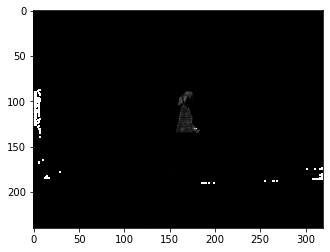

In [67]:
# first read in all images into a nice clean numpy array (because they are equal in dimension)
nImgs = 30
bgFrames = np.ndarray((background.shape[0], background.shape[1], nImgs))
for i in range(nImgs):
    if i < 10:
        bgFrames[:,:,i] = plt.imread("bg00"+str(i) +".bmp")
    else:
        bgFrames[:,:,i] = plt.imread("bg0"+str(i) +".bmp")

print(bgFrames.shape)
# get mean pixel per position 
mu = np.mean(bgFrames.astype(float),axis=2)
print(mu.shape)
# standard deviation of each pixel per position
sigmas = np.std(bgFrames.astype(float), axis=2)

# now let's do mahalonobis distance (for some reason there's 0 division, but it still works??)
extract2 = np.divide(np.square((walk.astype(float) - mu.astype(float))), np.square(sigmas.astype(float)))
plt.imshow(extract2, cmap='gray')

In [68]:
extractions2 = []
for t in T: # note the t^2
    plt.imsave("subtraction2_"+str(t) + ".png", extract2 > t*t, cmap="gray")
    extractions2.append(extract2 > t*t)

### T = 25

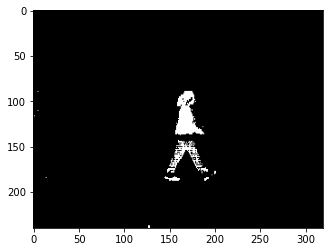

In [69]:
plt.imshow(extractions2[0], cmap='gray')

### T = 50

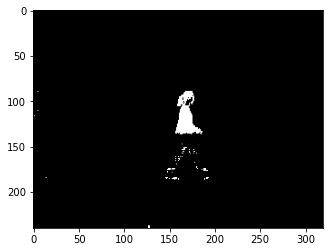

In [70]:
plt.imshow(extractions2[1], cmap='gray')

### T = 100

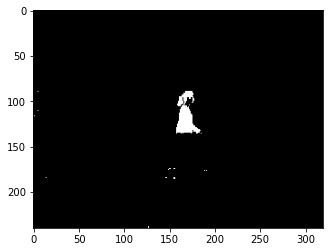

In [71]:
plt.imshow(extractions2[2], cmap='gray')

### T = 150

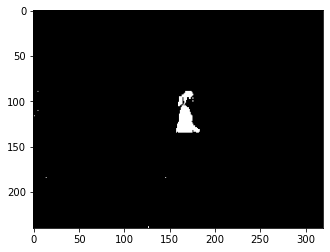

In [72]:
plt.imshow(extractions2[3], cmap='gray')

### T = 200

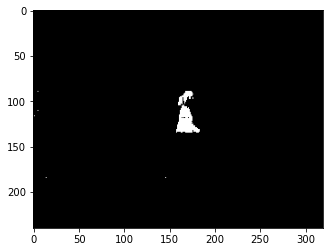

In [73]:
plt.imshow(extractions2[4], cmap='gray')

### Display all thresholdings (Also won't show in pdf version, please refer to above)


#### T = 25

![alt text](subtraction2_25.png "Title")

#### T = 50
![alt text](subtraction2_50.png "Title")
#### T = 100
![alt text](subtraction2_100.png "Title")
#### T = 150
![alt text](subtraction2_150.png "Title")

#### T = 200
![alt text](subtraction2_200.png "Title")

# Discussion:
#### So far it seems like T=25 is the best, since the other T*T or T^2 thresholds seem to eliminate her legs, let us try an even smaller T, like T= 20. Overall same trend as the first type of difference from #2.

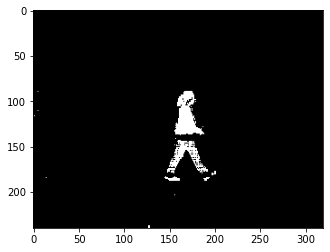

In [74]:
# we will 
t = 20
bestExtract2 = extract2 > t*t
plt.imshow(bestExtract2, cmap='gray')
plt.imsave('extract2best.png',bestExtract2,cmap='gray')
# 20 seems to eliminate the most noise!


# Q.4
Dilate your best binary image resulting from problem 3) using: [1 pt]
d_bsIm = bwmorph(bsIm, ‘dilate’);

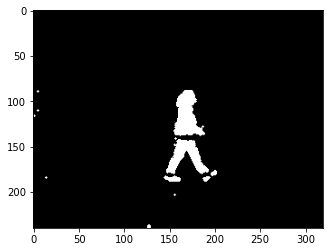

In [75]:
dilatedBestEx2 = scipy.ndimage.binary_dilation(bestExtract2) # bwmorph equivalent.
plt.imshow(dilatedBestEx2, cmap='gray')
plt.imsave('dilatedBest.png', dilatedBestEx2,cmap='gray')

# Discussion: 

As an aside, it's very interesting to see how all of the best images little holds were filled with a dilate. The person is now much fatter, but also rounder. We lose subtle detail interestingly in exchange for a more filled shape

# Q.5
Next perform a connected components algorithm, and keep only the largest region in
L (save/display as an image). [1 pt]

[L, num] = bwlabel(d_bsIm, 8);

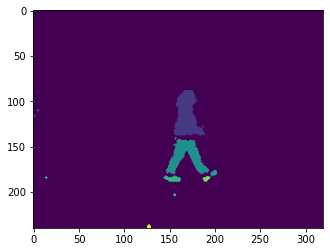

In [76]:
labeledDilatedIm = label(dilatedBestEx2) # bwmorph equivalent in python, tldr; each pixel in the labeled image is some specific integer/index, i.e region 2 == 2
regions = regionprops(labeledDilatedIm)
plt.imshow(labeledDilatedIm)

# plt.imshow(labeledDilatedIm[currentLargest.PixelIdxList])

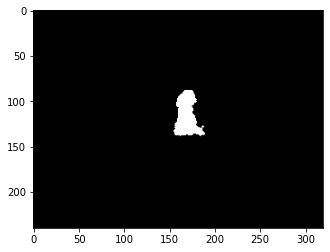

In [77]:
# sort for max region, in this case, we will get the index of the largest region!
currentLargest = np.argmax([i.area for i in regions])
pixelValOfLargest = currentLargest + 1
grayScaledVersionOfLargest = labeledDilatedIm == pixelValOfLargest
plt.imshow(grayScaledVersionOfLargest, cmap='gray')
plt.imsave('largestDilatedRegion.png' ,grayScaledVersionOfLargest, cmap='gray')

# Discussion:

Unsurprisingly, the person's torso and head was the largest region as it was fairly easy to see so in the earlier plot. Also, this makes sense because people are generally more "massy" on their torsos.